In [1]:
%matplotlib inline
from fastai2.vision.all import *
import typing
from sklearn.model_selection import train_test_split
import pycocotools.mask as mask_util
import matplotlib.patches as patches
import functools
import detection.utils as utils

In [2]:
dataset_root = Path("../dataset")
annotations_path = dataset_root / "via_region_data_fish_type.json"

In [3]:
with open(annotations_path) as f:
    annotations_data = list(json.load(f).values())
annotations_data_train, annotations_data_test = train_test_split(annotations_data, test_size=0.25)
len(annotations_data_train), len(annotations_data_test)

(40, 14)

In [4]:
def polygons_to_bitmask(polygons: typing.List[np.ndarray], height: int, width: int) -> np.ndarray:
    assert len(polygons) > 0, "COCOAPI does not support empty polygons"
    rles = mask_util.frPyObjects(polygons, height, width)
    rle = mask_util.merge(rles)
    return mask_util.decode(rle).astype(np.bool)


In [5]:
class FishDataset(object):
    def __init__(self, root, annotations_data, transforms = None):
        self.root = root
        self.annotations_data = list(annotations_data)
        self.transforms = transforms
        self.n_inp = 1


       
        
    def __getitem__(self, index):
        image, target = self._get(index)
        
        if self.transforms is not None:
            image, target = self.transforms(image, target)
        
        return image, target
        
    @functools.lru_cache(1000)
    def _get(self, index):
        data = self.annotations_data[index]
        file_path = data["filename"]
        image = Image.open(self.root / file_path).convert("RGB")
        
        boxes = []
        polygons = []
        labels = []
        masks = []
        
        for region in data["regions"]:
            shape_attributes = region["shape_attributes"]
            px = shape_attributes["all_points_x"]
            py = shape_attributes["all_points_y"]
            
            poly = [[x, y] for x, y in zip(px, py)]
            poly = [list(itertools.chain.from_iterable(poly))]
            mask = np.uint8(polygons_to_bitmask(poly, image.height, image.width))
            
            box = [min(px), min(py), max(px), max(py)]
            
            category_id = 1 #TODO
            
            boxes.append(box)
            masks.append(mask)
            labels.append(category_id)
           
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id =  torch.tensor([index])
    
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": areas,
            "iscrowd": torch.zeros((len(labels),), dtype=torch.int64)
        }
        
        return image, target
    
    
    def __len__(self):
        return len(self.annotations_data)

In [6]:
def plot_item(image, target):
    image = np.array(image)
    print(image.shape)
    

    ax = plt.axes()
    ax.imshow(image)
    

    for xmin, ymin, xmax, ymax in target["boxes"]:
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
    draw_mask = np.zeros(target["masks"][0].shape)
    for mask in target["masks"]:
        mask = np.array(mask)
        draw_mask += mask
    
    plt.imshow(draw_mask > 0, 'gray', interpolation='none', alpha=.5)

In [7]:
import detection.transforms as T

def get_transform():
    transforms = []
    transforms.append(T.ToTensor())
    #if train:
    #    transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


num_classes = 2

def create_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels 
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes,
    )
    
    return model
    




In [9]:
def params_splitter(model):
    return [params(model.backbone), params(model.rpn), params(model.roi_heads)]

In [10]:
train_ds = FishDataset(dataset_root, annotations_data_train,  get_transform())
valid_ds = FishDataset(dataset_root, annotations_data_test,  get_transform())

data_loader = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=4, 
    shuffle=True, 
    num_workers=4,
    collate_fn=utils.collate_fn
)

In [11]:
model = create_model(num_classes)



In [12]:
parameter_groups = params_splitter(model)
for o in parameter_groups[0] + parameter_groups[1]:
    o.requires_grad = False


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
"""
optimizer = torch.optim.SGD(
    params, 
    lr=1,
    momentum=0.9, 
    weight_decay=0.0005
)
"""
optimizer = torch.optim.Adam(params, lr=1)

from torch.optim.lr_scheduler import LambdaLR
start_lr=1e-7
end_lr=10

lrs = np.logspace(np.log10(start_lr), np.log10(end_lr))
def lambda_(epoch):
    print(lrs[epoch], epoch)
    return lrs[epoch]
lr_scheduler = LambdaLR(optimizer, lambda_)


model.train()
loss = []

i = 0
while i < len(lrs):
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        print(losses, math.isfinite(losses))
        
        if not math.isfinite(losses):
            i = len(lrs)
            break


        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()

        if len(loss) == 0:
            loss.append(losses)
        else:
            loss.append(0.9 * loss[-1] + 0.1 * losses)

        i += 1

        if i >= len(lrs):
            break
        
    


1e-07 0


/home/jordi/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914858187/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


tensor(5.9331, device='cuda:0', grad_fn=<AddBackward0>) True
1.4563484775012443e-07 1
tensor(6.4633, device='cuda:0', grad_fn=<AddBackward0>) True
2.1209508879201927e-07 2
tensor(5.7778, device='cuda:0', grad_fn=<AddBackward0>) True
3.0888435964774783e-07 3
tensor(5.9343, device='cuda:0', grad_fn=<AddBackward0>) True
4.498432668969444e-07 4
tensor(6.0961, device='cuda:0', grad_fn=<AddBackward0>) True
6.55128556859551e-07 5
tensor(6.0877, device='cuda:0', grad_fn=<AddBackward0>) True
9.540954763499944e-07 6
tensor(5.7725, device='cuda:0', grad_fn=<AddBackward0>) True
1.389495494373136e-06 7
tensor(5.1417, device='cuda:0', grad_fn=<AddBackward0>) True
2.0235896477251557e-06 8
tensor(5.6835, device='cuda:0', grad_fn=<AddBackward0>) True
2.94705170255181e-06 9
tensor(5.8673, device='cuda:0', grad_fn=<AddBackward0>) True
4.291934260128778e-06 10
tensor(5.3107, device='cuda:0', grad_fn=<AddBackward0>) True
6.250551925273976e-06 11
tensor(5.8012, device='cuda:0', grad_fn=<AddBackward0>) True


IndexError: index 50 is out of bounds for axis 0 with size 50

In [13]:
loss = np.array([l.cpu().detach().numpy() for l in loss])
loss

array([5.93306828e+00, 5.98609400e+00, 5.96526241e+00, 5.96216774e+00,
       5.97556162e+00, 5.98678064e+00, 5.96535015e+00, 5.88298702e+00,
       5.86303711e+00, 5.86346006e+00, 5.80817938e+00, 5.80748224e+00,
       5.68441105e+00, 5.57192087e+00, 5.49361849e+00, 5.30658579e+00,
       5.09484148e+00, 4.88325882e+00, 4.60737753e+00, 4.31546593e+00,
       4.02899170e+00, 3.81074500e+00, 3.57421541e+00, 3.33487391e+00,
       3.12386322e+00, 2.93653512e+00, 2.86355305e+00, 4.60853863e+00,
       4.30407572e+00, 4.18199730e+00, 4.15900183e+00, 4.20518494e+00,
       4.13919163e+00, 4.19693851e+00, 4.10720301e+00, 5.17212391e+00,
       6.49669838e+00, 2.90553093e+01, 3.49701843e+01, 3.58153076e+02,
       1.01738916e+03, 1.91851709e+03, 3.17944678e+03, 1.70591094e+05,
       1.96626531e+05, 2.87973500e+05, 2.29294825e+06, 9.12635000e+06,
       4.78933760e+07], dtype=float32)

In [14]:
len(loss), len(lrs)

(49, 50)

In [15]:
loss2 = loss[loss < 5 * np.min(loss)]
loss2

array([5.9330683, 5.986094 , 5.9652624, 5.9621677, 5.9755616, 5.9867806,
       5.96535  , 5.882987 , 5.863037 , 5.86346  , 5.8081794, 5.8074822,
       5.684411 , 5.571921 , 5.4936185, 5.306586 , 5.0948415, 4.883259 ,
       4.6073775, 4.315466 , 4.0289917, 3.810745 , 3.5742154, 3.334874 ,
       3.1238632, 2.9365351, 2.863553 , 4.6085386, 4.3040757, 4.1819973,
       4.159002 , 4.205185 , 4.1391916, 4.1969385, 4.107203 , 5.172124 ,
       6.4966984], dtype=float32)

0.0017575106248547893
0.00017575106248547893


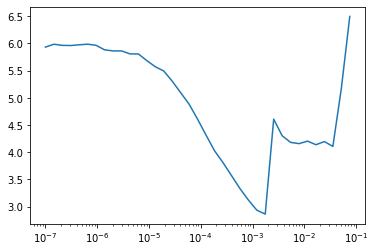

In [16]:
plt.plot(lrs[:len(loss2)], loss2)
plt.xscale("log")
print(lrs[np.argmin(loss)])
print(lrs[np.argmin(loss)] / 10)

In [18]:
model = create_model(2)
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

43922395